In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions.log_normal import LogNormal
from scipy.special import erfinv
from Helper.ImportDatasets import df_epsilon, df_epsilon_crit
from Method.calculate_distribution_a import distribution_a, calculate_s, calculate_mu_upper, integrand,log_normal_cdf



# Check how mu and s relate

In [2]:
thetas = torch.tensor([[1, 1.1, 0.9], [0.1, 0.2, 0.3]])
D = torch.tensor([5, 6, 7, 8, 9])

distr = torch.distributions.log_normal.LogNormal(thetas[0], thetas[1])
vals = distr.cdf(D[:, None])

def calculate_s(a, sigma, mu):
    return (np.log(a)-mu)/(erfinv(2*sigma - 1)*np.sqrt(2))

Text(0, 0.5, 's')

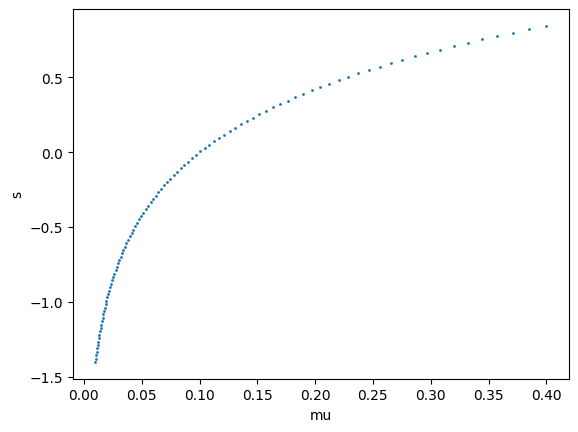

In [7]:
mu_upper = np.log(0.4)
mu_lower = np.log(0.01)

plt.scatter(np.exp(np.linspace(mu_lower, mu_upper, 100)), calculate_s(0.1, 0.05, np.linspace(mu_lower, mu_upper, 100)), s = 1)
plt.xlabel('mu')
plt.ylabel('s')

# Basically at np.log(a) = mu, s = 0, so we can sample uniformly from np.log(a) to mu_upper

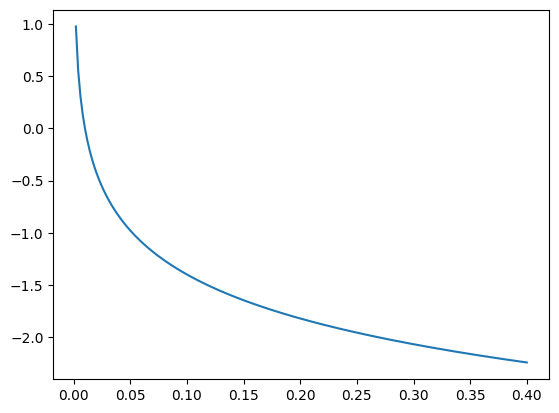

In [13]:
# what happens if we take area of a, e.g 0 to 0.001
a = torch.linspace(0,0.4,200)
mu = np.log(0.01)
ss = calculate_s(a,torch.tensor([0.05]),torch.tensor([mu]))
plt.plot(a,ss)

# Check upper limit of mu
If we want prob bigger than 0.4 to be 0.01

In [71]:
def common_constant(val):
    """
    Common constant when inverting log normal cdf

    :param val: usually P(x<x0) = val
    """
    return torch.erfinv(2 * val - 1)

def calculate_mu_upper(a, sigma, p = torch.tensor([0.01]), max_val = torch.tensor([0.4])):
    K = common_constant(1-p)/common_constant(sigma)
    return (K*torch.log(a) - torch.log(max_val))/(K-1)

In [55]:
a.detach().numpy()

array([0.01], dtype=float32)

In [112]:
a = torch.tensor([0.05])
sigma = torch.tensor([0.05])

mus = torch.linspace(np.log(a[0]+0.001), np.log(0.4), 10000)
ss = calculate_s(a, sigma, mus)

thetas = torch.stack([mus, ss])

distrs = torch.distributions.log_normal.LogNormal(thetas[0], thetas[1])
x = torch.full(mus.shape,0.4)
vals = distrs.cdf(x)

In [113]:
np.exp(mus)

tensor([0.0510, 0.0510, 0.0510,  ..., 0.3998, 0.3999, 0.4000])

In [114]:
np.exp(calculate_mu_upper(a, sigma))

tensor([0.1183])

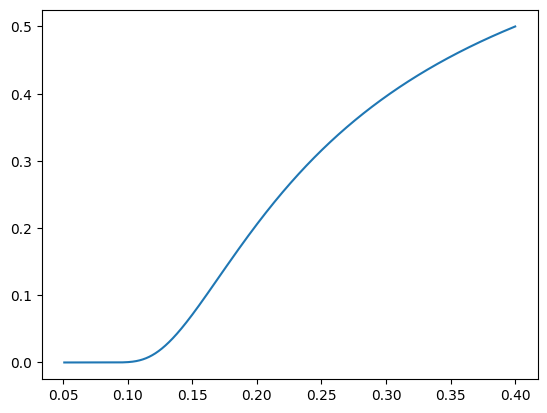

In [115]:
plt.plot(np.exp(mus), 1-vals)
#exponential x axis

tensor([0.2054])


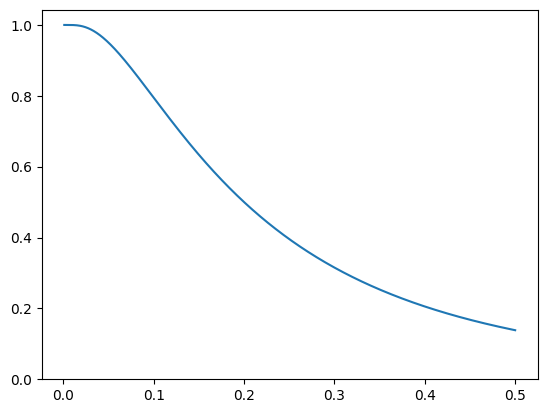

In [117]:
mu = torch.log(torch.tensor([0.2]))
distr_example = torch.distributions.log_normal.LogNormal(mu, calculate_s(a, sigma, mu))

# plot the distribution
x = torch.linspace(0.001, 0.5, 1000)
plt.plot(x, 1-distr_example.cdf(x))
plt.ylim(0)
print(1-distr_example.cdf(torch.tensor([0.4])))

# Test the funcionts if they work

In [7]:
#Gather Data
network = 'mnist-net'
df_for_network = df_epsilon[df_epsilon['network'] == network]
df_for_network = df_for_network[df_for_network['ds'] == 'test']
df_per_image = [df_for_network[df_for_network['image'] == i] for i in df_for_network['image'].unique()]

In [17]:
image = df_per_image[0]

# unsat means epsilon >, thus lower bound
lower_bound = np.max(image[image['result']=='unsat']['epsilon'].values)
# sat means epsilon <, thus upper bound
upper_bound = np.min(image[image['result']=='sat']['epsilon'].values)

a = torch.arange(0,0.4,step_size_a)
step_size_a = 0.001

In [18]:
D = torch.tensor([[lower_bound],[upper_bound]])
# Sample in our bins of 'a'
a_samples = torch.rand(100,*a.shape)*step_size_a+a

In [37]:
sigma = 0.05
n_samples = 1000
sigma = torch.tensor([sigma])

mu_lower = a_samples + 0.00001 # We add a small value to a to avoid s = 0
mu_upper = torch.exp(calculate_mu_upper(a_samples, sigma))
mus = torch.rand(n_samples, *a_samples.shape) * (mu_upper - mu_lower) + mu_lower
ss = calculate_s(a_samples, sigma, torch.log(mus))
thetas = torch.stack([mus, ss])

In [36]:
np.exp(mu_lower)

tensor([[9.4997e-04, 1.8562e-03, 2.5514e-03,  ..., 3.9708e-01, 3.9806e-01,
         3.9972e-01],
        [4.5724e-05, 1.2659e-03, 2.4473e-03,  ..., 3.9765e-01, 3.9868e-01,
         3.9977e-01],
        [2.3643e-04, 1.0106e-03, 2.8381e-03,  ..., 3.9766e-01, 3.9818e-01,
         3.9920e-01],
        ...,
        [1.0077e-03, 1.5568e-03, 2.3020e-03,  ..., 3.9724e-01, 3.9845e-01,
         3.9996e-01],
        [6.9393e-05, 1.5017e-03, 2.9922e-03,  ..., 3.9717e-01, 3.9880e-01,
         3.9997e-01],
        [1.4946e-04, 1.1277e-03, 2.8303e-03,  ..., 3.9781e-01, 3.9841e-01,
         3.9977e-01]])

In [ ]:


tries = log_normal_cdf(D[1]) - log_normal_cdf(D[0])

In [38]:



int = integrand(thetas, D)

In [39]:
int[torch.isnan(int) == False]

tensor([], dtype=torch.float64)

# Calculate distributions of a

In [4]:
import matplotlib.animation as animation
import random
"""
We pick sigma, delta, network and number of samples. Although delta doesn't matter much as the region of a we use is large enough to quickly find a solution where prob = 1
"""
def run(network, ani = False, shuffle = False, step_size_a = 0.001, sigma = 0.05, n_samples = 1000):
    delta = 0.05
    
    # Get the network and test set, then split the images
    df_for_network = df_epsilon[df_epsilon['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_per_image = [df_for_network[df_for_network['image'] == i] for i in df_for_network['image'].unique()]
    
    # We find the distribution of 'a' for the following bins
    a = torch.arange(0,0.4,step_size_a)
    
    # We keep track of the distributions of 'a' and its max probability
    distributions_of_a = []
    
    # Initialize D (dataset) and the default value to put in if we don't find elligible epsilons
    D = torch.tensor([[],[]],dtype=torch.float32)
    default = torch.tensor([[0],[0.4]],dtype=torch.float32)
    
    if shuffle:
        random.shuffle(df_per_image)
    
    for i,image in enumerate(df_per_image):
        # We put in the default value first and then change it to the lower and upper bound of the image
        D = torch.cat((D,default),dim=1)
        
        # unsat means epsilon >, thus lower bound
        lower_bound = np.max(image[image['result']=='unsat']['epsilon'].values)
        # sat means epsilon <, thus upper bound
        upper_bound = np.min(image[image['result']=='sat']['epsilon'].values)
        D[0,-1] = lower_bound
        D[1,-1] = upper_bound
        
        print(f"image {i+1}")
        
        # Sample in our bins of 'a'
        a_samples = torch.rand(100,*a.shape)*step_size_a+a
        # We calculate the distribution of each sample
        distr = distribution_a(a_samples,D,sigma,n_samples)
        max_distr = torch.max(distr)
        distributions_of_a.append(distr)
        
        # We check if we have attained a probability of at least 1-delta
        if max_distr > 1-delta:
            print('found')
            break
        
        # Most likely the above will not happen but the distribution of 'a' will become too peaked to fit in the range of a that has been given
        # In that case we are also satisfied as we know 'a' is in a small enough region
        if torch.isnan(max_distr):
           distributions_of_a.pop()
           print('found: region is too small')
           break
    
    if ani:
        fig, ax = plt.subplots()
    
        ax.set_ylim(0, 1)
        line, = ax.plot(a, np.tile(0,len(a)))
        
        
        def animate(i):
            line.set_ydata(distributions_of_a[i])  # update the data.
            return line,
        
        
        ani = animation.FuncAnimation(
            fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)
        
        # To save the animation, use e.g.
        #
        ani.save(network+".gif")
    
    return distributions_of_a

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

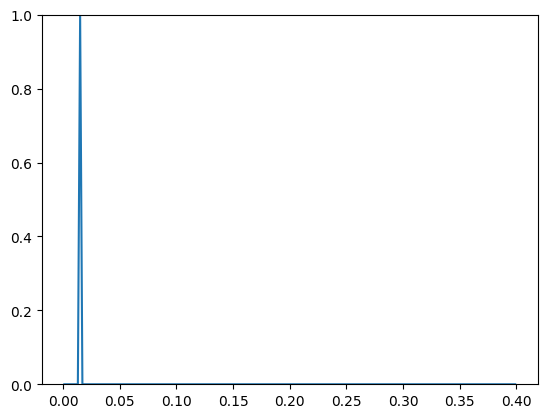

In [14]:
# Save as animation
import matplotlib.animation as animation

fig, ax = plt.subplots()

ax.set_ylim(0, 1)
line, = ax.plot(a, np.tile(0,len(a)))


def animate(i):
    line.set_ydata(distributions_of_a[i])  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)

# To save the animation, use e.g.
#
ani.save(network+".gif")

In [ ]:
distrs = []
for network in df_epsilon['network'].unique():
    distrs.append(run(network))

In [38]:
import pandas as pd

a = torch.linspace(0.001,0.399,200)
df_distr_a = pd.DataFrame(columns=['a','network','image','probability'])
for i,net in enumerate(distrs):
    network = df_epsilon['network'].unique()[i]
    for j,distr in enumerate(net):
        temp_df = pd.DataFrame(columns=['a','network','image','probability'])
        temp_df['a'] = a
        temp_df['probability'] = distr
        temp_df['network'] = network
        temp_df['image'] = j
        df_distr_a = pd.concat([df_distr_a,temp_df])

In [42]:
# save as csv and as excel
df_distr_a.to_csv('distr_a.csv')
df_distr_a.to_excel('distr_a.xlsx')
df_distr_a

,a,network,image,probability
0,0.001,mnist-net,0,0.012807
1,0.003,mnist-net,0,0.016432
2,0.005,mnist-net,0,0.019386
3,0.007,mnist-net,0,0.021908
4,0.009,mnist-net,0,0.023915
...,...,...,...,...
195,0.391,mnist_relu_9_200,23,0.000000
196,0.393,mnist_relu_9_200,23,0.000000
197,0.395,mnist_relu_9_200,23,0.000000
198,0.397,mnist_relu_9_200,23,0.000000


In [5]:
# How much does the random sampling matter?
network = 'mnist-net'

step_size_a = 0.001
a = torch.arange(0,0.4,step_size_a)
final_distr = []
values = np.tile(np.nan,(2,100)).astype(np.float32)
for i in range(10):
    temp_distr = run(network, ani=False, shuffle = True)[-1].numpy()
    final_distr.append(temp_distr)
    temp_as = a[temp_distr > 0]
    values[0,i] = np.min(temp_as)
    values[1,i] = np.max(temp_as)
    print(i+1 + "/10 done")

# save the files
np.save('values.npy',values)
np.save('final_distr.npy',np.array(final_distr))
    

image 1
found: region is too small


IndexError: list index out of range

(array([ 5.,  0.,  0., 25.,  0.,  0., 24.,  0.,  0.,  0., 22.,  0.,  0.,
        16.,  0.,  0.,  6.,  0.,  0.,  2.]),
 array([0.007 , 0.0076, 0.0082, 0.0088, 0.0094, 0.01  , 0.0106, 0.0112,
        0.0118, 0.0124, 0.013 , 0.0136, 0.0142, 0.0148, 0.0154, 0.016 ,
        0.0166, 0.0172, 0.0178, 0.0184, 0.019 ]),
 <BarContainer object of 20 artists>)

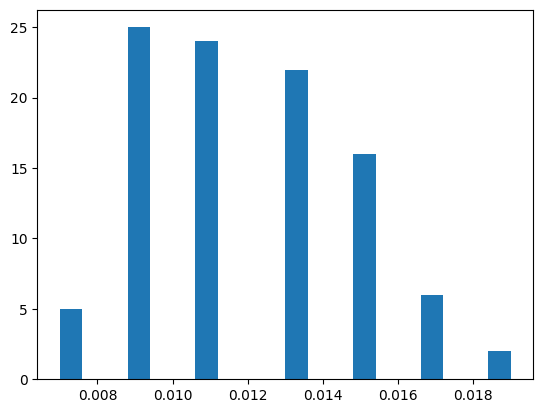

In [56]:
#make histogram
plt.hist(values[0,:],bins=[20])

In [57]:
values

array([[0.015, 0.011, 0.013, 0.011, 0.011, 0.009, 0.011, 0.013, 0.011,
        0.011, 0.011, 0.009, 0.007, 0.015, 0.007, 0.009, 0.009, 0.009,
        0.009, 0.017, 0.009, 0.015, 0.011, 0.007, 0.015, 0.013, 0.013,
        0.011, 0.009, 0.013, 0.013, 0.007, 0.009, 0.013, 0.013, 0.015,
        0.017, 0.017, 0.011, 0.013, 0.017, 0.013, 0.015, 0.013, 0.011,
        0.011, 0.015, 0.009, 0.009, 0.013, 0.009, 0.015, 0.011, 0.013,
        0.011, 0.013, 0.009, 0.015, 0.009, 0.009, 0.011, 0.015, 0.015,
        0.013, 0.015, 0.009, 0.013, 0.009, 0.015, 0.011, 0.011, 0.013,
        0.009, 0.011, 0.011, 0.015, 0.013, 0.017, 0.011, 0.011, 0.009,
        0.013, 0.009, 0.011, 0.013, 0.007, 0.013, 0.009, 0.009, 0.009,
        0.019, 0.009, 0.017, 0.015, 0.011, 0.009, 0.013, 0.015, 0.019,
        0.011],
       [0.021, 0.021, 0.021, 0.025, 0.015, 0.017, 0.019, 0.021, 0.017,
        0.017, 0.013, 0.015, 0.013, 0.015, 0.015, 0.021, 0.017, 0.017,
        0.021, 0.019, 0.017, 0.017, 0.017, 0.019, 0.021, 0.01

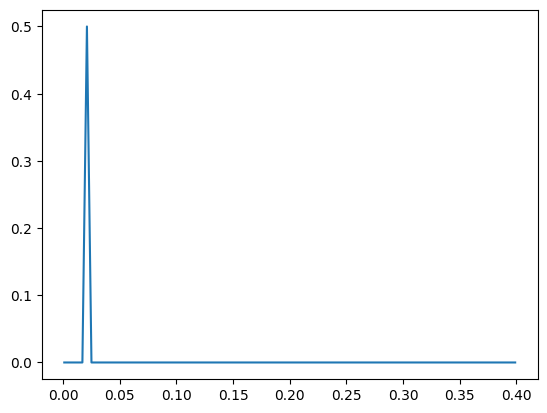

In [60]:
plt.plot(a,final_distr[98])

In [59]:
final_distr[12]

array([-0.        , -0.        ,  0.        ,  0.16666667,  0.33333334,
        0.33333334,  0.16666667,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

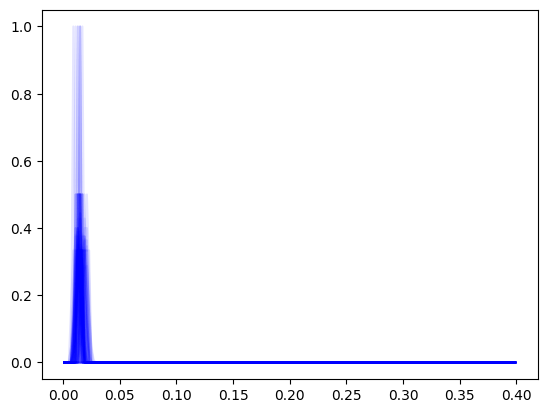

In [64]:
for distr in final_distr:
    plt.plot(a,distr, alpha = 0.1, c = 'b')

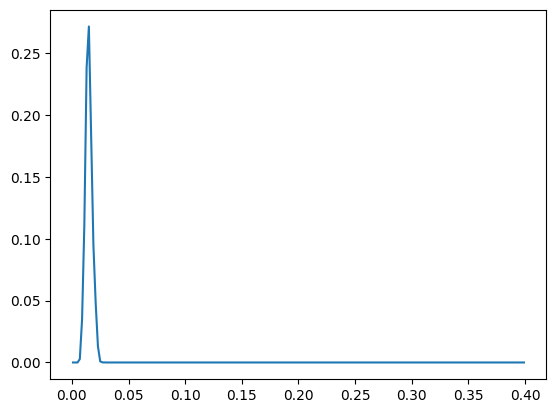

In [72]:
final_distr = np.array(final_distr)
means = np.mean(final_distr, axis = 0)
plt.plot(a,means)